# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
#from tensorflow.nn import relu, softmax

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)
    return(smote_x, smote_y)


def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']

In [4]:
file_name = 'tab_tick'
#file_name = 'full_tab_tick'

In [5]:
df = pd.read_csv('data/'+file_name+'_2019.csv')
#df.drop(remove_cols, axis=1, inplace=True)
df.head(5)

,spread_avg,spread_cls_diff,tick_opn_diff,tick_high_diff,tick_low_diff,tick_cls_diff,tick_avg_diff,tick_sd,tick_ema_10_diff,tick_ema_25_diff,...,tick_ema_75_diff,tick_ema_diff,ema_gap,gain,loss,avg_gain,avg_loss,rsi,tick_slope,direction
0,0.000405,0.00025,0.000025,0.000130,-0.000020,0.000055,0.000035,0.000060,0.000056,0.000071,...,0.000063,0.000053,0.000003,0.000035,0.000000,0.000019,0.000033,36.630037,8.526058,same
1,0.000531,-0.00029,0.000050,0.000065,0.000030,0.000145,0.000057,0.000058,0.000099,0.000021,...,0.000010,0.000027,0.000072,0.000057,0.000000,0.000023,0.000033,41.189802,-3.724729,decrease
2,0.000375,0.00012,0.000145,-0.000010,-0.000275,-0.000430,-0.000132,0.000125,-0.000373,-0.000296,...,-0.000204,-0.000179,-0.000194,0.000000,0.000132,0.000023,0.000043,35.201212,-19.796746,same
3,0.000522,0.00025,-0.000400,-0.000305,-0.000005,-0.000045,-0.000201,0.000065,-0.000097,-0.000086,...,-0.000144,-0.000164,0.000066,0.000000,0.000201,0.000023,0.000043,35.277537,-6.967128,same
4,0.000633,0.00014,-0.000055,-0.000015,-0.000010,0.000070,0.000020,0.000056,0.000092,0.000068,...,0.000061,0.000045,0.000047,0.000020,0.000000,0.000025,0.000037,39.812039,3.870720,increase


In [6]:
target_col = 'direction'
x_scaled, y_encoded, y_map, scaler_obj = data_prep(df, apply_smote = False)
joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

Record count : 291851
--------------------------
same        259793
decrease     16392
increase     15666
Name: direction, dtype: int64
--------------------------
same        0.890156
decrease    0.056166
increase    0.053678
Name: direction, dtype: float64


['data/model/y_map.pkl']

In [7]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

## XGBOOST

In [8]:
%%time
clf_xg = xgboost.XGBClassifier()
rounded_train_y = np.argmax(train_y, axis = -1)

clf_xg.fit(train_x, rounded_train_y)
joblib.dump(clf_xg, 'data/model/model_xg.pkl') 

predictions = clf_xg.predict(valid_x)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, predictions, target_names = y_map.values()))

[16:14:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

    decrease       0.38      0.03      0.06      3354
    increase       0.33      0.03      0.05      3158
        same       0.89      1.00      0.94     51859

    accuracy                           0.89     58371
   macro avg       0.54      0.35      0.35     58371
weighted avg       0.83      0.89      0.84     58371

Wall time: 1min 18s


Record count : 260475
--------------------------
same        165914
decrease     47378
increase     47183
Name: direction, dtype: int64
--------------------------
same        0.636967
decrease    0.181891
increase    0.181142
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.46      0.01      0.02     47378
    increase       0.47      0.01      0.02     47183
        same       0.64      1.00      0.78    165914

    accuracy                           0.64    260475
   macro avg       0.52      0.34      0.27    260475
weighted avg       0.58      0.64      0.50    260475

Wall time: 2.47 s


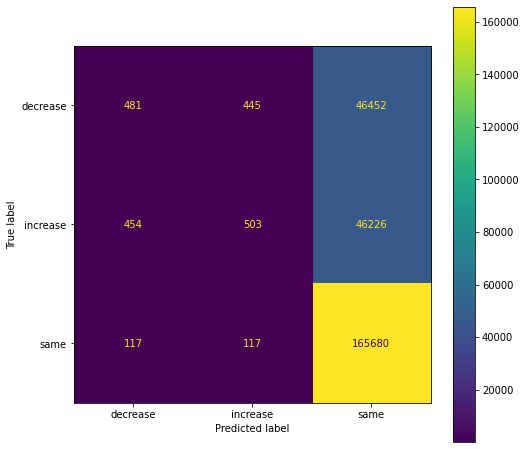

In [12]:
%%time
df1 = pd.read_csv('data/'+file_name+'_2018.csv')
#df1.drop(remove_cols, axis=1, inplace=True)

x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

clf_xg = joblib.load('data/model/model_xg.pkl') 
predictions = clf_xg.predict(x_scaled1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in predictions]
#df1.to_csv('data/'+file_name+'_2018_res.csv')

print(classification_report(rounded_valid_y, predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

<AxesSubplot:>

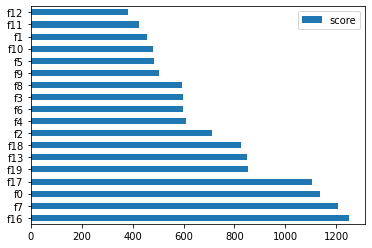

In [13]:
feature_important = clf_xg.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 
x_scaled = scaler_obj.transform(live_df.values)

predictions = clf_xg.predict(x_scaled)

live_df['predictions'] = [y_map[k] for k in predictions]

print(y_map)
live_df['predictions'].value_counts()

In [11]:
winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)